In [3]:
import json
import random
import numpy as np
import pandas as pd


In [8]:
malware_file = 'amd_malware_metadata/pca_data_dict.txt'

with open(malware_file, 'r') as data_file:
    mlw_data = json.load(data_file)


In [9]:
# remove those malware whose features set is different.
features = ['0x04000', '0x02700', '0x02902', '0x02B00', '0x02904', '0x03000']
rm = []
for m in mlw_data:
    for sample in mlw_data[m]:
        if set(features) != set(mlw_data[m][sample]):
            rm.append(m)
        else:
            mlw_data[m][sample] = np.array(list(mlw_data[m][sample].values()))

for m in rm:
    if m in mlw_data:
        del mlw_data[m]


In [10]:
malware = {}
for m in mlw_data.keys():
    for each_sample in mlw_data[m]:
        if m not in malware:
            malware[m] = np.reshape(mlw_data[m][each_sample], (1, 6, 32))
        else:
            mlw = np.reshape(mlw_data[m][each_sample], (1, 6, 32))
            malware[m] = np.vstack((malware[m], mlw))


In [11]:
malware['000165f414b9a1437d45e33249663200'].shape

(32, 6, 32)

### specify family

In [12]:
malware_fam = {}
with open('fam_data/myth_label.txt', 'r') as jk:
    for line in jk:
        l = line.strip().split("\t")
        if l[1].startswith("SINGLETON:"):
            l[1] = l[1].split(":")[0]
        if l[0] in malware:
            if l[1] not in malware_fam.keys():
                malware_fam[l[1]] = malware[l[0]]
            else:
                malware_fam[l[1]] = np.vstack(
                    (malware_fam[l[1]], malware[l[0]]))


In [13]:
malware_fam['beebone'].shape


(1561, 6, 32)

Load Benign Data.

In [14]:
benign_files = 'amd_desktop_metadata/pca_data_dict.txt'

with open(benign_files, 'r') as data_file:
    bgn_data = json.load(data_file)


In [15]:
features = ['0x04000', '0x02700', '0x02902', '0x02B00', '0x02904', '0x03000']
rm = []
for b in bgn_data:
    for sample in bgn_data[b]:
        if set(features) != set(bgn_data[b][sample]):
            rm.append(b)
        else:
            bgn_data[b][sample] = np.array(list(bgn_data[b][sample].values()))

for b in rm:
    if b in bgn_data:
        del bgn_data[b]


In [16]:
benign = {}
for b in bgn_data.keys():
    for each_sample in bgn_data[b]:
        if b not in benign:
            benign[b] = np.reshape(bgn_data[b][each_sample], (1, 6, 32))
        else:
            bn = np.reshape(bgn_data[b][each_sample], (1, 6, 32))
            benign[b] = np.vstack((benign[b], bn))


In [17]:
benign_data = None
for b in benign:
    if benign_data is None:
        benign_data = np.array(benign[b])
    else:
        benign_data = np.vstack((benign_data, benign[b]))


In [18]:
benign_data.shape


(43658, 6, 32)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import time


In [107]:
class learnAll:
    def __init__(self, malware, benign):
        self.malware_data = malware
        self.benign_data = benign

        malware_label = np.ones(len(malware))
        benign_label = np.zeros(len(benign_data))
        sample_size = min(len(benign_label), len(malware_label))
        self.data = np.vstack((
            random.sample(list(benign_data), sample_size),
            random.sample(list(malware), sample_size)
        ))
        self.label = np.concatenate((
            random.sample(list(benign_label), sample_size),
            random.sample(list(malware_label), sample_size)
        ))

    def setup_train_test_split(self):
        """
        Setup_train_test_split uses default split (scikit-learn split) to separate the 
        training and testing dataset.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data, self.label, test_size=0.1,
            random_state=random.randint(0, 2**32 - 1))

    def setup_classifiers(self):
        """
        setup_classifiers only generate the classifier class objects. nothing more.
        """
        self.names = [
            "Nearest Neighbors", "Decision Tree",
            "Random Forest",
            "AdaBoost", "Naive Bayes",
            "Neural Net" \
            # "Logistic Regression",\
            # "Linear SVM", "Rbf SVM", "Poly SVM", "Sigmoid SVM"\
            # , "Gaussian Process"
        ]
        max_iterations = 1000
        self.classifiers = [
            KNeighborsClassifier(
                n_neighbors=5, weights='uniform', algorithm='auto', n_jobs=-1),
            DecisionTreeClassifier(
                max_depth=100, min_samples_split=12, min_samples_leaf=12,
                max_features=None,
                random_state=int(round(time.time()))),
            RandomForestClassifier(max_depth=100, min_samples_split=12,
                                   min_samples_leaf=12,
                                   n_estimators=100, max_features=None,
                                   random_state=int(round(time.time()))),
            AdaBoostClassifier(algorithm='SAMME.R', n_estimators=200,
                               random_state=int(round(time.time()))),
            GaussianNB(priors=[0.5, 0.5]),
            MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100),
                          alpha=100, solver='lbfgs',
                          max_iter=max_iterations,
                          activation='tanh', tol=1e-5,
                          warm_start='True') \
            # LogisticRegression(penalty='l2', tol=1e-4, C=1e2,\
            # fit_intercept=True, solver='lbfgs', \
            # class_weight='balanced', max_iter=max_iterations), \
            # SVC(kernel="linear", C=1e2, tol=1e-4, max_iter=max_iterations,\
            # probability= True),\
            # SVC(kernel="rbf", C=1e2, tol=1e-4, max_iter=max_iterations,\
            # probability=True, shrinking=True),
            # SVC(kernel="poly", C=1e2, degree=4, tol=1e-4,\
            # max_iter=max_iterations, probability=True),\
            # SVC(kernel="sigmoid", C=1e2, gamma=1e-1, tol=1e-3, \
            # max_iter=max_iterations, probability=True, \
            # shrinking=True)#,\
            # GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=-1, \
            # copy_X_train=False, \
            # max_iter_predict=100, warm_start=False )\
        ]
        # self.classifiers = [ \
        #                 LogisticRegression(penalty='l2', tol=1e-9, C=1,\
        #                   fit_intercept=True, solver='lbfgs', \
        #                   class_weight='balanced', max_iter=max_iterations*100, n_jobs=-1) \
        #                 ]

    def text_class_report(self, names):
        """
        Text_class_report for experiment log files. text report updates the self.report 
        to log the results in the terminal. The results include precision, recall, f1_score
        and support. The results are dumped into classification report. The labels are 0 and 1.
        """
        # results
        precision, recall, f1_score, support = \
            precision_recall_fscore_support(self.y_test, self.prediction,
                                            beta=1.0, average='binary', labels=[0, 1], pos_label=0)
        self.report[names] = {}
        self.report[names]['precision'] = precision
        self.report[names]['recall'] = recall
        self.report[names]['f1_score'] = f1_score
        self.report[names]['support'] = support
        self.report[names]['param'] = \
            self.classifiers[self.names.index(names)].get_params()

        # with open(self.result_path + 'classification_report.txt', 'w') as outfile:
        #     json.dump(self.report, outfile, indent=2)
        # outfile.close()

    def roc_curve_report(self, name):
        """
        Use fpr and tpr information to record the roc information.
        """
        fpr, tpr, _ = roc_curve(
            self.y_test, self.predict_proba[:, 0], pos_label=0)
        roc_auc = auc(fpr, tpr)
        self.report[name]['fpr'] = list(fpr)
        self.report[name]['tpr'] = list(tpr)
        self.report[name]['roc_auc'] = roc_auc

        # with open(self.result_path + 'classification_

    def run(self):
        """
        run function has the minimum experimental setup. It uses the basic training and 
        testing split.
        """

        self.setup_train_test_split()
        self.setup_classifiers()
        self.report = {}
        for names, clf in zip(self.names, self.classifiers):
            print(names + " in process ....")
            # train
            clf.fit(self.X_train, self.y_train)
            # if names == 'Decision Tree':
            #     tree.export_graphviz(clf, out_file=self.result_path + 'tree.dot')
            # test

            self.prediction = clf.predict(self.X_test)
            self.text_class_report(names)

            self.predict_proba = clf.predict_proba(self.X_test)
            self.roc_curve_report(names)

            print(names + " testing completed!")

    def cv_text_class_report(self, names):
        """
        cv_text_class_report generates logs for cross validation results.
        """
        chunk_length = len(self.label) / 10
        self.report[names] = {}
        for idx in range(10):
            precision, recall, f1_score, support = \
                precision_recall_fscore_support(
                    self.label[idx * chunk_length: (idx + 1) * chunk_length],
                    self.prediction[idx *
                                    chunk_length: (idx + 1) * chunk_length],
                    beta=1.0, average='binary', labels=[0, 1], pos_label=0)
            self.report[names][idx] = {}
            self.report[names][idx]['precision'] = precision
            self.report[names][idx]['recall'] = recall
            self.report[names][idx]['f1_score'] = f1_score
            self.report[names][idx]['support'] = support

        # with open(self.result_path + 'cv_classification_report.txt', 'w') as outfile:
        #     json.dump(self.report, outfile, indent=2)
        # outfile.close()

    def classic_cross_validation(self):
        """
        classic_cross_validation runs cross validation with ALL the data in the feature
        vectors. It does NOT separate feature vectors between training and testing dataset.
        """
        print('Start to cross validate ...')
        self.setup_classifiers()
        self.report = {}
        for names, clf in zip(self.names, self.classifiers):
            self.logger.info(names + " in process ....")
            # test
            zipped_list = zip(self.data, self.label)
            random.shuffle(zipped_list)
            self.data, self.label = zip(*zipped_list)
            self.data = list(self.data)
            self.label = list(self.label)
            self.prediction = cross_val_predict(
                clf, self.data, self.label, cv=10)
            self.cv_text_class_report(names)

            print(names + " testing completed!")


In [109]:
learn = learnAll(malware_fam['SINGLETON'], benign_data)


In [111]:
# learn.run()


In [20]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


In [55]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(
        filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(
        filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(
        filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [56]:
m = malware_fam['SINGLETON']
malware_label = np.ones(len(m))
benign_label = np.zeros(len(benign_data))
sample_size = min(len(benign_label), len(malware_label))
data = np.vstack((
    random.sample(list(benign_data), sample_size),
    random.sample(list(m), sample_size)
))
label = np.concatenate((
    random.sample(list(benign_label), sample_size),
    random.sample(list(malware_label), sample_size)
))


In [62]:
from sklearn.preprocessing import StandardScaler


In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    data, label, test_size=0.1,
    random_state=random.randint(0, 2**32 - 1))


In [77]:
X_train.shape


array([[[ 0.07331232, -0.076946  , -0.10331428, ..., -0.04000768,
         -0.04410298,  1.1253458 ],
        [ 0.07332419, -0.07694078, -0.10330861, ..., -0.04000684,
         -0.04410269,  1.12559395],
        [ 0.07331796, -0.07694352, -0.1033102 , ..., -0.040007  ,
         -0.04410284,  1.12554352],
        [ 0.07331632, -0.07694424, -0.10331059, ..., -0.04000704,
         -0.04410288,  1.12553153],
        [ 0.07331952, -0.07694284, -0.1033098 , ..., -0.04000696,
         -0.0441028 ,  1.12555501],
        [ 0.0733141 , -0.07694523, -0.10331115, ..., -0.04000737,
         -0.04410293,  1.12551364]],

       [[-0.36756814, -0.42297146, -0.37304295, ..., -0.29758558,
         -0.29277723, -0.48313629],
        [-0.36754257, -0.42295988, -0.37303577, ..., -0.2975849 ,
         -0.2927766 , -0.48294801],
        [-0.36756405, -0.42296972, -0.37304184, ..., -0.29758548,
         -0.29277713, -0.48310536],
        [-0.3675653 , -0.42297027, -0.37304218, ..., -0.29758551,
         -0.29

In [64]:
scaler = StandardScaler()
X_train = scaler.fit_transform(
    X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(
    X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


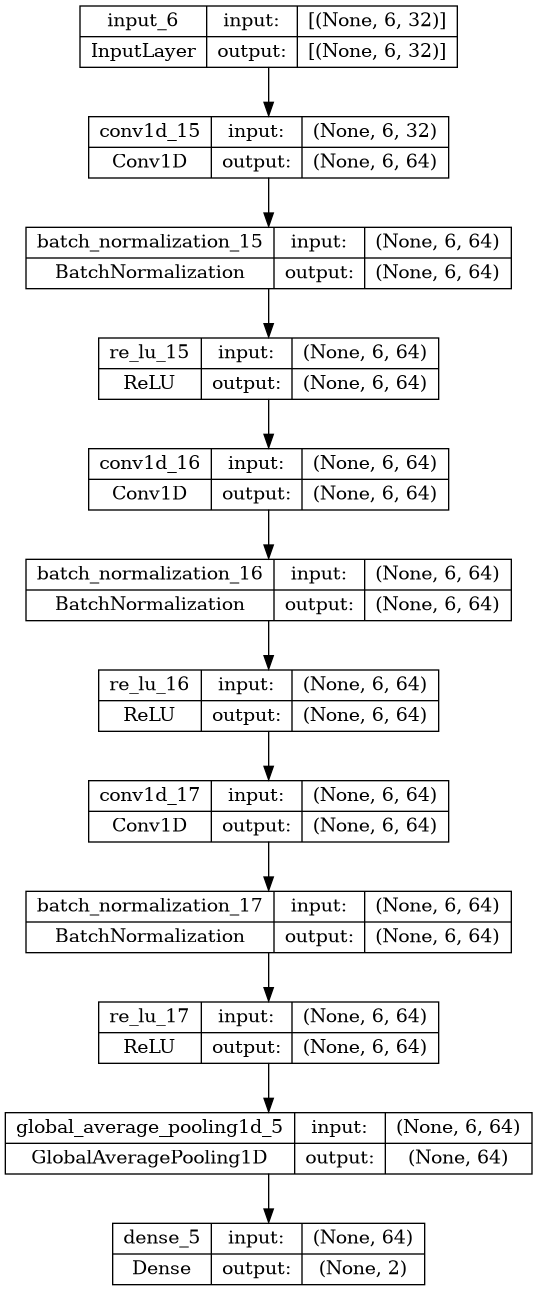

In [65]:
model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)


In [78]:
import tensorflow as tf
epochs = 50
batch_size = 64
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    # callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/50
29/29 [==============================] - 3s 25ms/step - loss: 0.4695 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.9756 - val_sparse_categorical_accuracy: 0.4957
Epoch 2/50
29/29 [==============================] - 0s 10ms/step - loss: 0.4286 - sparse_categorical_accuracy: 0.7843 - val_loss: 1.1292 - val_sparse_categorical_accuracy: 0.4957
Epoch 3/50
29/29 [==============================] - 0s 10ms/step - loss: 0.4199 - sparse_categorical_accuracy: 0.7778 - val_loss: 1.1552 - val_sparse_categorical_accuracy: 0.4957
Epoch 4/50
29/29 [==============================] - 0s 10ms/step - loss: 0.3997 - sparse_categorical_accuracy: 0.8105 - val_loss: 1.2922 - val_sparse_categorical_accuracy: 0.4957
Epoch 5/50
29/29 [==============================] - 0s 9ms/step - loss: 0.3961 - sparse_categorical_accuracy: 0.7990 - val_loss: 1.3053 - val_sparse_categorical_accuracy: 0.4957
Epoch 6/50
29/29 [==============================] - 0s 10ms/step - loss: 0.3847 - sparse_categorical_accur

In [75]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)


8/8 [==============================] - 0s 4ms/step - loss: 0.7172 - sparse_categorical_accuracy: 0.5078
Test accuracy 0.5078125
Test loss 0.717166543006897


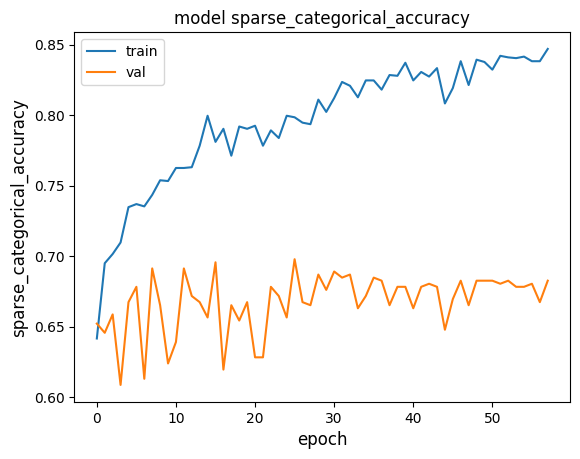

In [29]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


In [35]:
benign_files = ['amd_desktop_metadata/pca_data_dict.txt']
# 'amd_python_benign_metadata/pca_data_dict.txt'

benign_dict = {}
benign_data = []

for files in benign_files:
    with open(files, 'r') as data_file:
        json_data = json.load(data_file)

    for bm in json_data.keys():
        benign_dict[bm] = False
        for each_sample in json_data[bm]:
            if benign_data == []:
                benign_data = np.array(each_sample)
            else:
                benign_data = np.vstack((benign_data, each_sample))

    data_file.close()


/tmp/ipykernel_60704/2543433918.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if benign_data == []:


In [40]:
malware_files = ['amd_malware_metadata/pca_data_dict.txt']

malware_data = {}

for files in malware_files:
    with open(files, 'r') as data_file:
        json_data = json.load(data_file)

    for bm in json_data.keys():
        for each_sample in json_data[bm]:
            if bm not in malware_data:
                malware_data[bm] = np.array(json_data[bm][each_sample])
            else:
                try:
                    malware_data[bm] = np.vstack(
                        (malware_data[bm], json_data[bm][each_sample]))
                except:
                    continue

    data_file.close()


In [28]:
# malware_data['0004e4b3ca40685076d69a4733c2866a']
